In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score ,accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

print("Training shape: ", train_data.shape)
print("Test shape: ", test_data.shape)
print(train_data.head())
print(train_data.info())
print(train_data.describe())
print(test_data.head())
print(test_data.info())
print(test_data.describe())

Training shape:  (891, 12)
Test shape:  (418, 11)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4    

<bound method NDFrame.describe of 0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64>


C:\Users\HP\AppData\Local\Temp\ipykernel_12560\1413392859.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=train_data, palette='coolwarm')


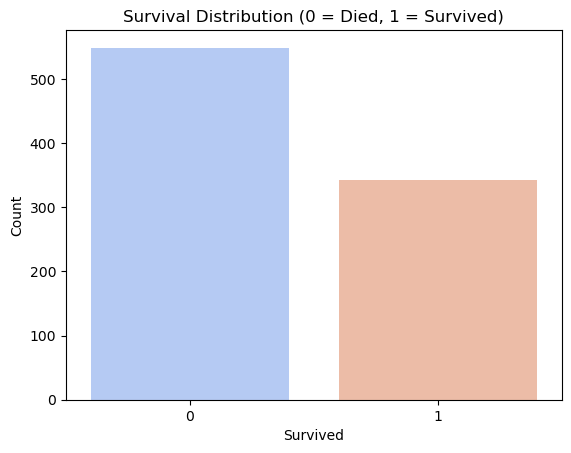

In [21]:
target = "Survived"
print(train_data[target].describe)
sns.countplot(x='Survived', data=train_data, palette='coolwarm')
plt.title('Survival Distribution (0 = Died, 1 = Survived)')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

In [22]:
train_data['dataset_train'] = 1
test_data['dataset_train'] = 0
test_data[target] = np.nan

combined = pd.concat([train_data, test_data], ignore_index=True)

for col in combined.select_dtypes(include=np.number).columns:
    combined[col] = combined[col].fillna(combined[col].median())

for col in combined.select_dtypes(include=['object']).columns:
    combined[col] = combined[col].fillna(combined[col].mode()[0])

combined['Sex'] = combined['Sex'].map({'male': 0, 'female': 1})

combined['Title'] = combined['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
combined['Title'] = combined['Title'].replace(['Mlle', 'Ms'], 'Miss')
combined['Title'] = combined['Title'].replace(['Mme'], 'Mrs')
rare_titles = combined['Title'].value_counts()[combined['Title'].value_counts() < 10].index
combined['Title'] = combined['Title'].replace(rare_titles, 'Rare')

combined.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

combined = pd.get_dummies(combined, drop_first=True)

train_clean = combined[combined['dataset_train'] == 1].drop(['dataset_train'], axis=1)
test_clean = combined[combined['dataset_train'] == 0].drop(['dataset_train', target], axis=1)

In [23]:
X = train_clean.drop(target, axis=1)
y = train_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.fit_transform(X_test)
test_scaled = scaler.fit_transform(test_clean)

In [24]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train_res)
y_pred = model.predict(X_test_scaled)

In [25]:
accuracy = accuracy_score(y_test, y_pred)
confx = confusion_matrix(y_test, y_pred)
creport = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", round(accuracy, 4))
print("F1 Score:", round(f1, 4))
print("\nConfusion Matrix:\n", confx)
print("\nClassification Report:\n", creport)

Accuracy: 0.8101
F1 Score: 0.7875

Confusion Matrix:
 [[82 23]
 [11 63]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.78      0.83       105
         1.0       0.73      0.85      0.79        74

    accuracy                           0.81       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.82      0.81      0.81       179



In [26]:
cv_scores = cross_val_score(model, X_train_scaled, y_train_res, cv=5)
print("Mean Cross Validation:", cv_scores.mean())

Mean Cross Validation: 0.8255252967688694


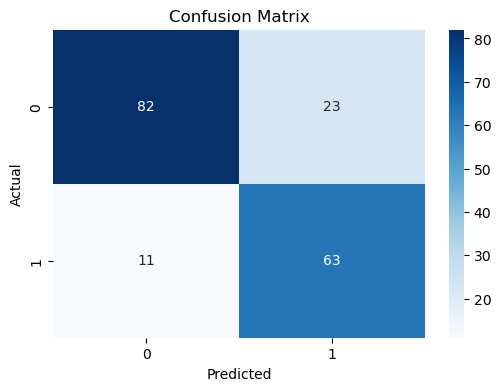

In [27]:
plt.figure(figsize=(6,4))
sns.heatmap(confx, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [28]:
test_predictions = model.predict(test_scaled)

submission = pd.DataFrame({
    "Id": test_data["PassengerId"],
    "Survived": test_predictions
})

submission.to_csv("binary_classification.csv", index=False)
print("binary_classification.csv file saved.")

binary_classification.csv file saved.


In [29]:
joblib.dump(model, "binary_classification_model.pkl")
joblib.dump(scaler, "scaler_binary_classification.pkl")

['scaler_binary_classification.pkl']

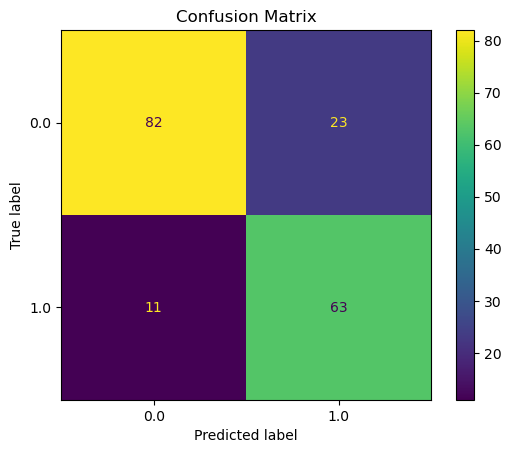

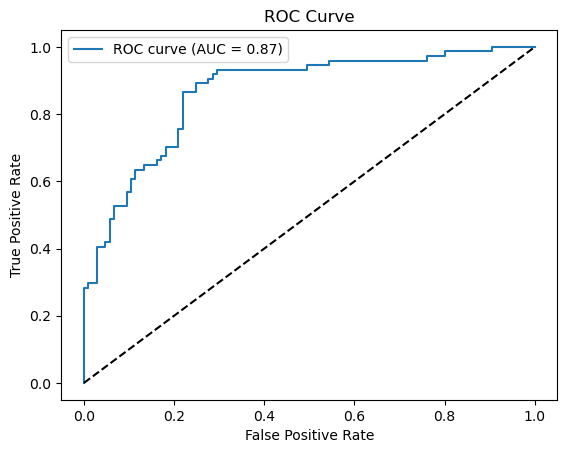

In [30]:
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()